# VocDetection 데이터셋 생성 코드
- 첫번째 작성한 데이터셋으로는 모델이 수렴하지 않아 개선 방법 중 하나로 작은 객체를 제거하는 것을 선택
- normalized width, height가 1.5 이하인 객체는 제거하는 방향으로 진행
- 데이터 개수가 적은 관계로 test dataset 생성은 생략하고 train dataset 비중을 늘림

In [1]:
from torchvision import datasets

- 공식 문서 : https://pytorch.org/vision/main/generated/torchvision.datasets.VOCDetection.html#torchvision.datasets.VOCDetection`

In [2]:
dataset_dir = r'D:\AI\Dataset'

dataset = datasets.VOCDetection(
    root=dataset_dir,
    year='2012',
    image_set='train',
    download=False,
    transform=None,
)

In [3]:
import os
from glob import glob

path = os.path.join(dataset_dir, 'VOCdevkit/VOC2012/Annotations/*.xml')
paths = glob(path)
len(paths)

17125

- 데이터 개수 : 2007~2012년도 자료 총합 17125개

In [4]:
import xml.etree.ElementTree as ET
import os
from glob import glob
from tqdm import tqdm

def xml_to_list(xml_paths, file_dir, voc_classes, format='pascal_voc', resized_img_size=448):

    '''
    입력: 
        xml_paths: (list) xml paths
        file_dir: txt 파일 저장 경로
        voc_classes: VocDetection의 클래스 이름
        format: bounding box format, albumentations 형식 참조

    파일 이름: filename.txt

    데이터 형식: [class_name, xmin, ymin, xmax, ymax]

    difficult가 1인 데이터는 객체의 형태가 불분명하여 데이터에서 삭제
    '''
    
    voc_classes = {key:value for value, key in enumerate(voc_classes)}

    for xml_path in tqdm(xml_paths):
        root = ET.parse(xml_path).getroot()

        filename = root.find('filename').text.split('.')[0] # 0001.jpg -> 0001
        
        width = float(root.find('size').find('width').text)
        height = float(root.find('size').find('height').text)
        img_size = [width, height]

        objects = root.findall('object')
        annotations = []
        for obj in objects:
            class_name = obj.find('name').text
            class_name = voc_classes[str(class_name)]
            difficult = obj.find('difficult').text
            xmin = float(obj.find('bndbox').find('xmin').text)
            ymin = float(obj.find('bndbox').find('ymin').text)
            xmax = float(obj.find('bndbox').find('xmax').text)
            ymax = float(obj.find('bndbox').find('ymax').text)
            coordinate = [xmin, ymin, xmax, ymax]

            # 패딩된 이미지를 기준으로 하였을 때
            # normalized width, height가 1.5 이하인 객체 제외
            # yolo format에서의 1.5 이하를 말하는 것이 아님
            # 그리드셀 사이즈 7
            if width >= height:
                max_size = width
            else:
                max_size = height
            resize_ratio = resized_img_size / max_size
            resized_width = 7 * resize_ratio * (xmax - xmin) / resized_img_size
            resized_height = 7 * resize_ratio * (ymax - ymin) / resized_img_size

            if (resized_height < 1.5) or (resized_width < 1.5):
                continue

            if difficult == 1:
                continue

            # 데이터 format 변환
            coord = convert_box_format(img_size, coordinate, format)
            annotations.append([class_name, coord[0], coord[1], coord[2], coord[3]])
        
        # 객체가 존재하지 않을 경우 파일 생성 금지
        if len(annotations) > 0:
            file_path = os.path.join(file_dir, filename + '.txt')
            with open(file_path, 'w') as f:
                for class_name, coord1, coord2, coord3, coord4 in annotations:
                    f.write(f'{class_name},{coord1},{coord2},{coord3},{coord4}\n') # csv format

def convert_box_format(img_size, coordinate, format):

    '''
    Albumentations annotation formats:
        https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

    Bounding box format:
        pascal_voc -> [x_min, y_min, x_max, y_max]
        albumentations -> normalized [x_min, y_min, x_max, y_max]
        coco -> [x_min, y_min, width, height]
        yolo -> normalized [x_center, y_center, width, height]
    '''

    img_width, img_height = img_size
    xmin, ymin, xmax, ymax = coordinate

    if format == 'pascal_voc':
        # [x_min, y_min, x_max, y_max]
        coord1 = xmin
        coord2 = ymin
        coord3 = xmax
        coord4 = ymax
    elif format == 'albumentations':
        # normalized [x_min, y_min, x_max, y_max]
        coord1 = xmin / img_width
        coord2 = ymin / img_height
        coord3 = xmax / img_width
        coord4 = ymax / img_height
    elif format == 'coco':
        # [x_min, y_min, width, height]
        coord1 = xmin
        coord2 = ymin
        coord3 = xmax - xmin
        coord4 = ymax - ymin
    elif format == 'yolo':
        # normalized [x_center, y_center, width, height]
        coord1 = (xmin + xmax) / 2 / img_width
        coord2 = (ymin + ymax) / 2 / img_height
        coord3 = (xmax - xmin) / img_width
        coord4 = (ymax - ymin) / img_height

    converted_coordinate = [coord1, coord2, coord3, coord4]

    return converted_coordinate

In [5]:
# 테스트용 코드
dataset_dir = r'D:\AI\Dataset'

xml_dir = os.path.join(dataset_dir, 'VOCdevkit/VOC2012/Annotations/*.xml')
xml_paths = glob(xml_dir)
label_dir = './'
voc_classes = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

xml_to_list(xml_paths[:3], label_dir, voc_classes, format='yolo')

100%|██████████| 3/3 [00:00<00:00, 187.45it/s]


# 폴더 생성

In [6]:
import os

def makedirs(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [7]:
img_dir = os.path.join(dataset_dir, 'VocDetection/images')
label_dir = os.path.join(dataset_dir, 'VocDetection/labels')

makedirs(img_dir)
makedirs(label_dir)

In [8]:
xml_dir = os.path.join(dataset_dir, 'VOCdevkit/VOC2012/Annotations/*.xml')
xml_paths = glob(xml_dir)
voc_classes = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

xml_to_list(xml_paths, label_dir, voc_classes, format='yolo')

100%|██████████| 17125/17125 [01:14<00:00, 229.43it/s]


In [9]:
len(glob(os.path.join(label_dir, '*.txt')))

13485

- bbox 2 이하의 객체를 거른 결과 17125개의 이미지 중 13485개의 이미지가 남음

# 이미지 이동

In [29]:
import shutil
import os
from glob import glob
from tqdm import tqdm

src_img_dir = os.path.join(dataset_dir, 'VOCdevkit/VOC2012/JPEGImages')
dst_img_dir = img_dir
filenames = glob(os.path.join(src_img_dir, '*.jpg'))
for filename in tqdm(filenames):
    filename = filename.split('\\')[-1]
    src = os.path.join(src_img_dir, filename)
    dst = os.path.join(dst_img_dir, filename)
    shutil.copy(src, dst)

100%|██████████| 17125/17125 [01:16<00:00, 224.44it/s]


# csv 생성 후 분석

In [10]:
def create_csv(csv_file, file_paths):

    '''
    입력: (list) image or txt file 주소
    데이터 형식: (csv) [filename.jpg, filename.txt]
    '''
    
    with open(csv_file, 'w') as f:
        for file_path in file_paths:
            filename = file_path.split('\\')[-1].split('.')[0]
            img_name = filename + '.jpg'
            txt_name = filename + '.txt'

            f.write(f'{img_name},{txt_name}\n')

In [11]:
import random
from glob import glob

label_path = os.path.join(label_dir, '*.txt')
label_paths = glob(label_path)

# 전체 데이터를 랜덤 셔플 후 분할
random.shuffle(label_paths)
data_cnt = len(label_paths)
split_ratios = [0.9, 0.1]

train_cnt = int(split_ratios[0] * data_cnt)
valid_cnt = data_cnt - train_cnt

train_csv_path = os.path.join(dataset_dir, 'VocDetection/train.csv')
valid_csv_path = os.path.join(dataset_dir, 'VocDetection/valid.csv')

create_csv(train_csv_path, label_paths[:train_cnt])
create_csv(valid_csv_path, label_paths[train_cnt:])

## 연습용 데이터셋 작성

In [13]:
import os
import pandas as pd

data_len = 16
# data_len = 128

sample_path = os.path.join(dataset_dir, f'VocDetection/{data_len}_sample_train.csv')
train_df = pd.read_csv(train_csv_path, header=None)
train_df = train_df[:data_len]
train_df.to_csv(sample_path, index=False, header=None)

sample_path = os.path.join(dataset_dir, f'VocDetection/{data_len}_sample_valid.csv')
valid_df = pd.read_csv(valid_csv_path, header=None)
valid_df = valid_df[:data_len]
valid_df.to_csv(sample_path, index=False, header=None)

# 분포 확인 및 분석

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from tqdm import tqdm

def create_df(csv_file, label_dir):
    voc_classes = [
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'pottedplant',
        'sheep',
        'sofa',
        'train',
        'tvmonitor'
    ]
    index_to_class = {i:class_name for i, class_name in enumerate(voc_classes)}

    columns = [
        'class_name',
        'x_center',
        'y_center',
        'width',
        'height'
    ]
    df = pd.DataFrame(data=[], columns=columns)

    annotations = pd.read_csv(csv_file)

    df_index = 0
    for index in tqdm(range(len(annotations))):
        label_path = os.path.join(label_dir, annotations.iloc[index, 1])

        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, w, h = list(label.split(','))
                class_name = index_to_class[int(class_label)]
                df.loc[df_index] = [class_name, float(x), float(y), float(w), float(h)]
        
                df_index += 1

    return df

In [6]:
train_df = create_df(train_csv_path, label_dir)
valid_df = create_df(valid_csv_path, label_dir)

  0%|          | 0/12135 [00:00<?, ?it/s]

100%|██████████| 1348/1348 [00:06<00:00, 201.77it/s]


In [7]:
print(train_df.head())
print(valid_df.head())

    class_name  x_center  y_center     width    height
0  diningtable  0.602000  0.813333  0.304000  0.373333
1       person  0.502273  0.501000  0.977273  0.998000
2          car  0.499000  0.602941  0.742000  0.526738
3       person  0.322000  0.302667  0.404000  0.600000
4       person  0.636000  0.560000  0.352000  0.848000
  class_name  x_center  y_center     width    height
0     person  0.497333  0.508000  0.621333  0.984000
1    bicycle  0.582000  0.474667  0.688000  0.549333
2     person  0.726000  0.756000  0.256000  0.488000
3        dog  0.166000  0.821333  0.272000  0.320000
4     person  0.293000  0.694667  0.330000  0.610667


## 클래스 개수

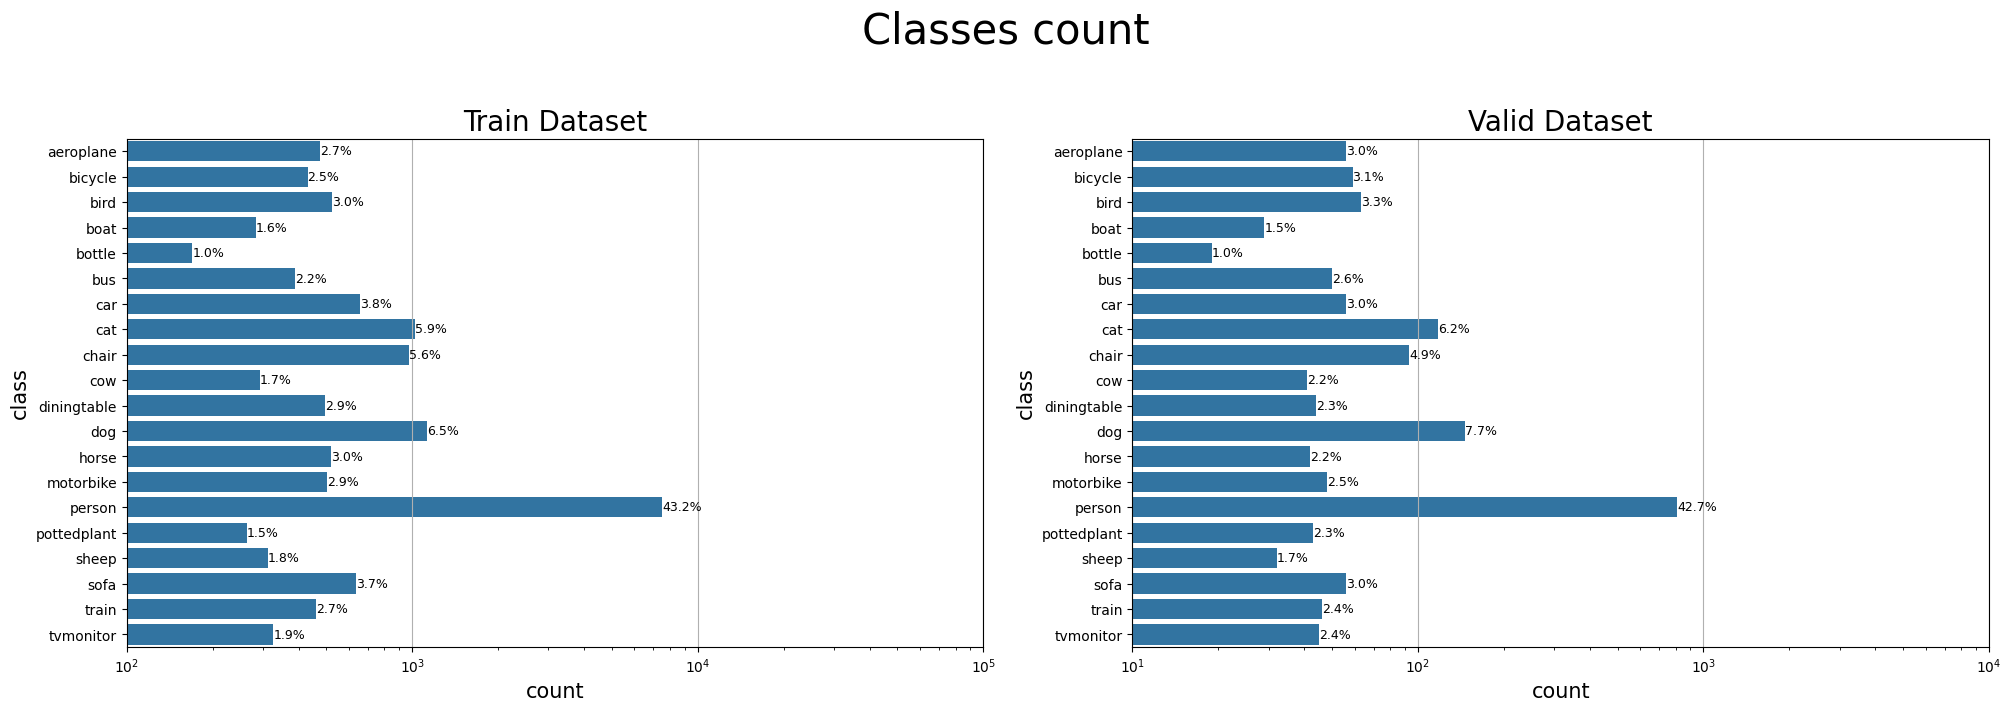

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

voc_classes = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

def write_percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        y = p.get_y()
        percentage = width / total * 100
        ax.text(width, y+height/2, f'{percentage:0.1f}%', va='center', size = 9)

fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Classes count\n', fontsize=30)

sns.countplot(y=train_df['class_name'], order=voc_classes, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_xlabel('count', fontsize=15)
axes[0].set_xlim([1e2, 1e5])
axes[0].set_ylabel('class', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='x')
total = train_df['class_name'].count()
write_percentage(axes[0], total)

sns.countplot(y=valid_df['class_name'], order=voc_classes, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('count', fontsize=15)
axes[1].set_xlim([1e1, 1e4])
axes[1].set_ylabel('class', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='x')
total = valid_df['class_name'].count()
write_percentage(axes[1], total)

## 객체가 존재하는 grid cell 비율

In [20]:
print(f'train dataset 객체 총 개수: {len(train_df)}개')
print(f'train dataset 전체 이미지 개수: {12135}개')
print(f'train dataset grid cell 비율: {100*len(train_df) / (12135 * 49):.1f}%')
print(f'train dataset 이미지 한 장당 객체 수: {len(train_df) / 12135:.1f}개')
print()

print(f'valid dataset 객체 총 개수: {len(valid_df)}개')
print(f'valid dataset 전체 이미지 개수: {1348}개')
print(f'valid dataset grid cell 비율: {100*len(valid_df) / (1348 * 49):.1f}%')
print(f'valid dataset 이미지 한 장당 객체 수: {len(valid_df) / 1348:.1f}개')

train dataset 객체 총 개수: 17352개
train dataset 전체 이미지 개수: 12135개
train dataset grid cell 비율: 2.9%
train dataset 이미지 한 장당 객체 수: 1.4개

valid dataset 객체 총 개수: 1894개
valid dataset 전체 이미지 개수: 1348개
valid dataset grid cell 비율: 2.9%
valid dataset 이미지 한 장당 객체 수: 1.4개


## Bounding box 가로 세로 폭

In [10]:
print(train_df['width'].min(), train_df['width'].max())
print(valid_df['width'].min(), valid_df['height'].max())

0.21458333333333332 0.998
0.216 0.998


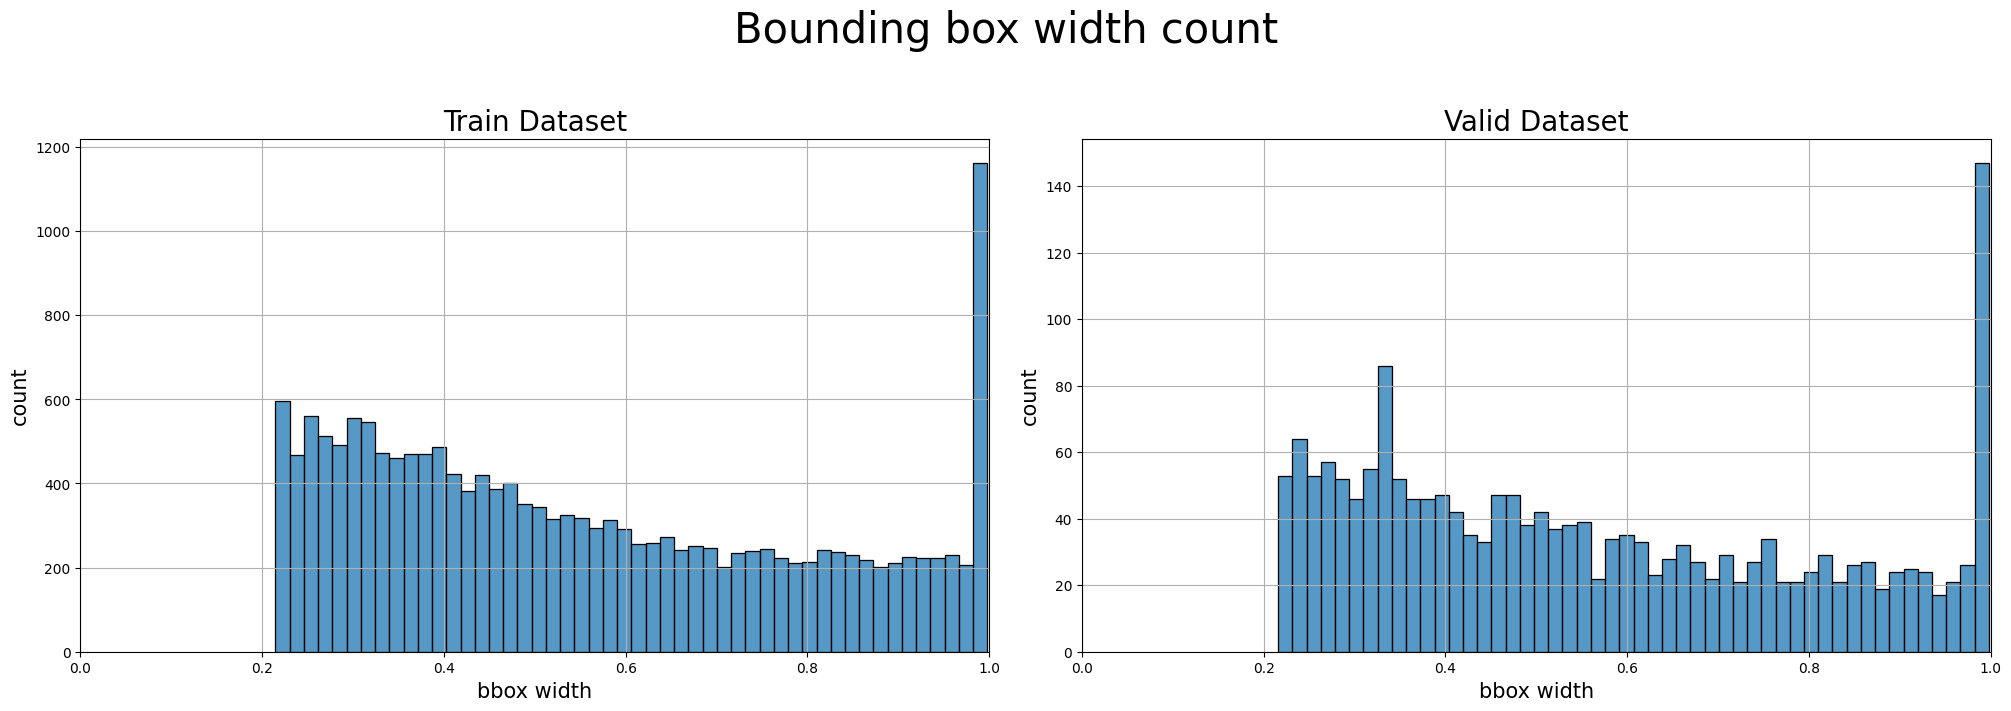

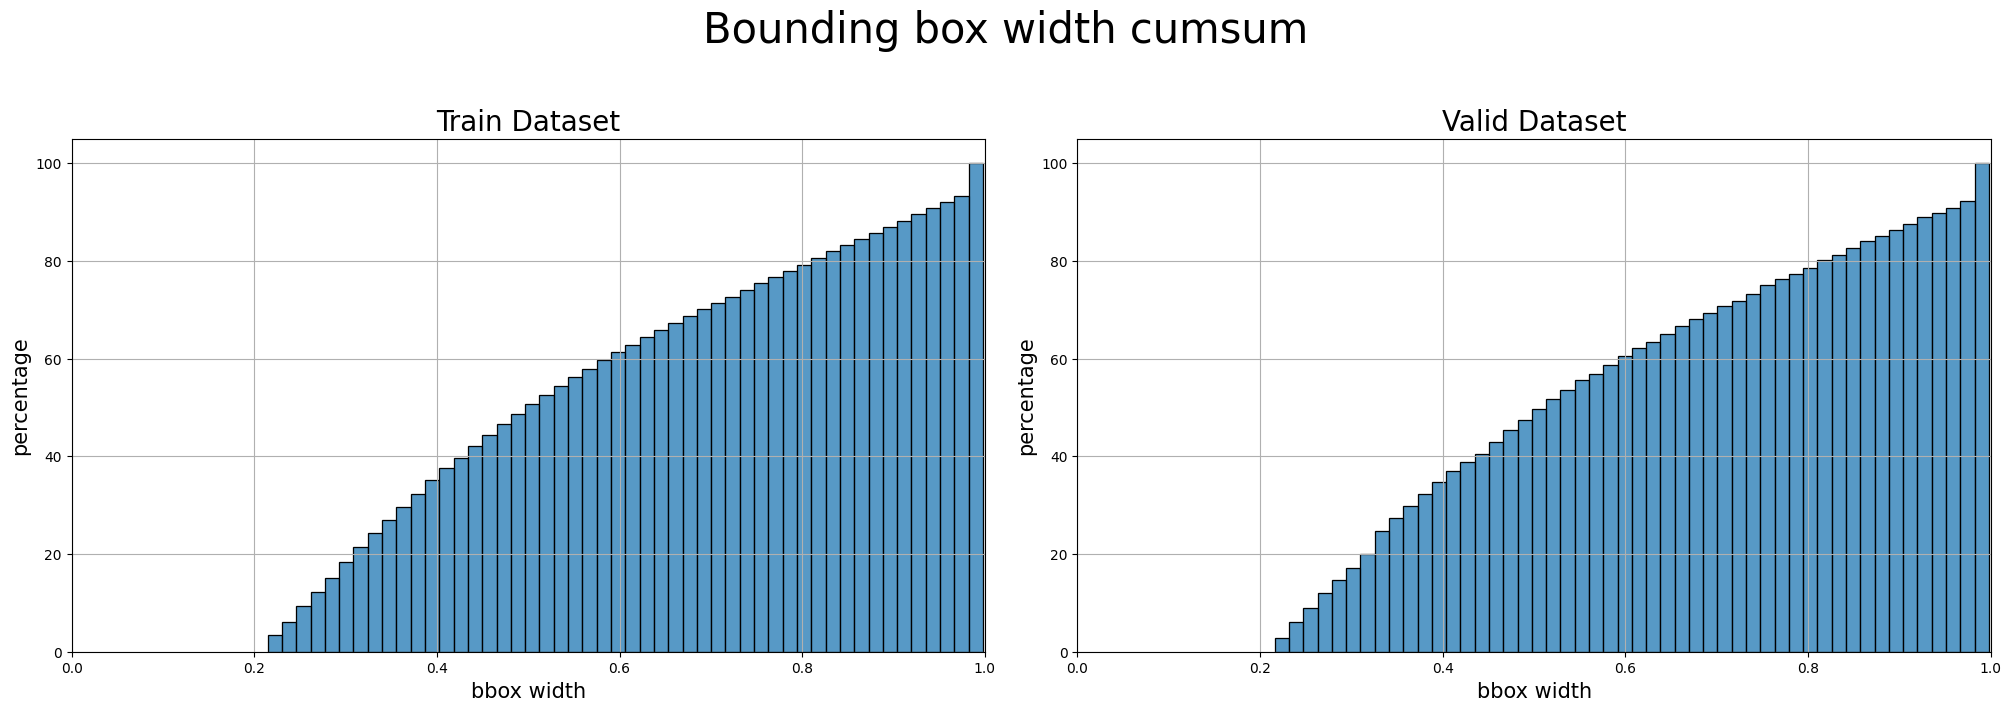

In [11]:
xlim = [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Bounding box width count\n', fontsize=30)

sns.histplot(x=train_df['width'], bins=50, ax=axes[0])
axes[0].set_xlabel('bbox width', fontsize=15)
axes[0].set_xlim(xlim)
axes[0].set_ylabel('count', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='both')

sns.histplot(x=valid_df['width'], bins=50, ax=axes[1])
axes[1].set_xlabel('bbox width', fontsize=15)
axes[1].set_xlim(xlim)
axes[1].set_ylabel('count', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='both')



fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Bounding box width cumsum\n', fontsize=30)

sns.histplot(x=train_df['width'], bins=50, cumulative=True, stat='percent', ax=axes[0])
axes[0].set_xlabel('bbox width', fontsize=15)
axes[0].set_xlim(xlim)
axes[0].set_ylabel('percentage', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='both')

sns.histplot(x=valid_df['width'], bins=50, cumulative=True, stat='percent', ax=axes[1])
axes[1].set_xlabel('bbox width', fontsize=15)
axes[1].set_xlim(xlim)
axes[1].set_ylabel('percentage', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='both')

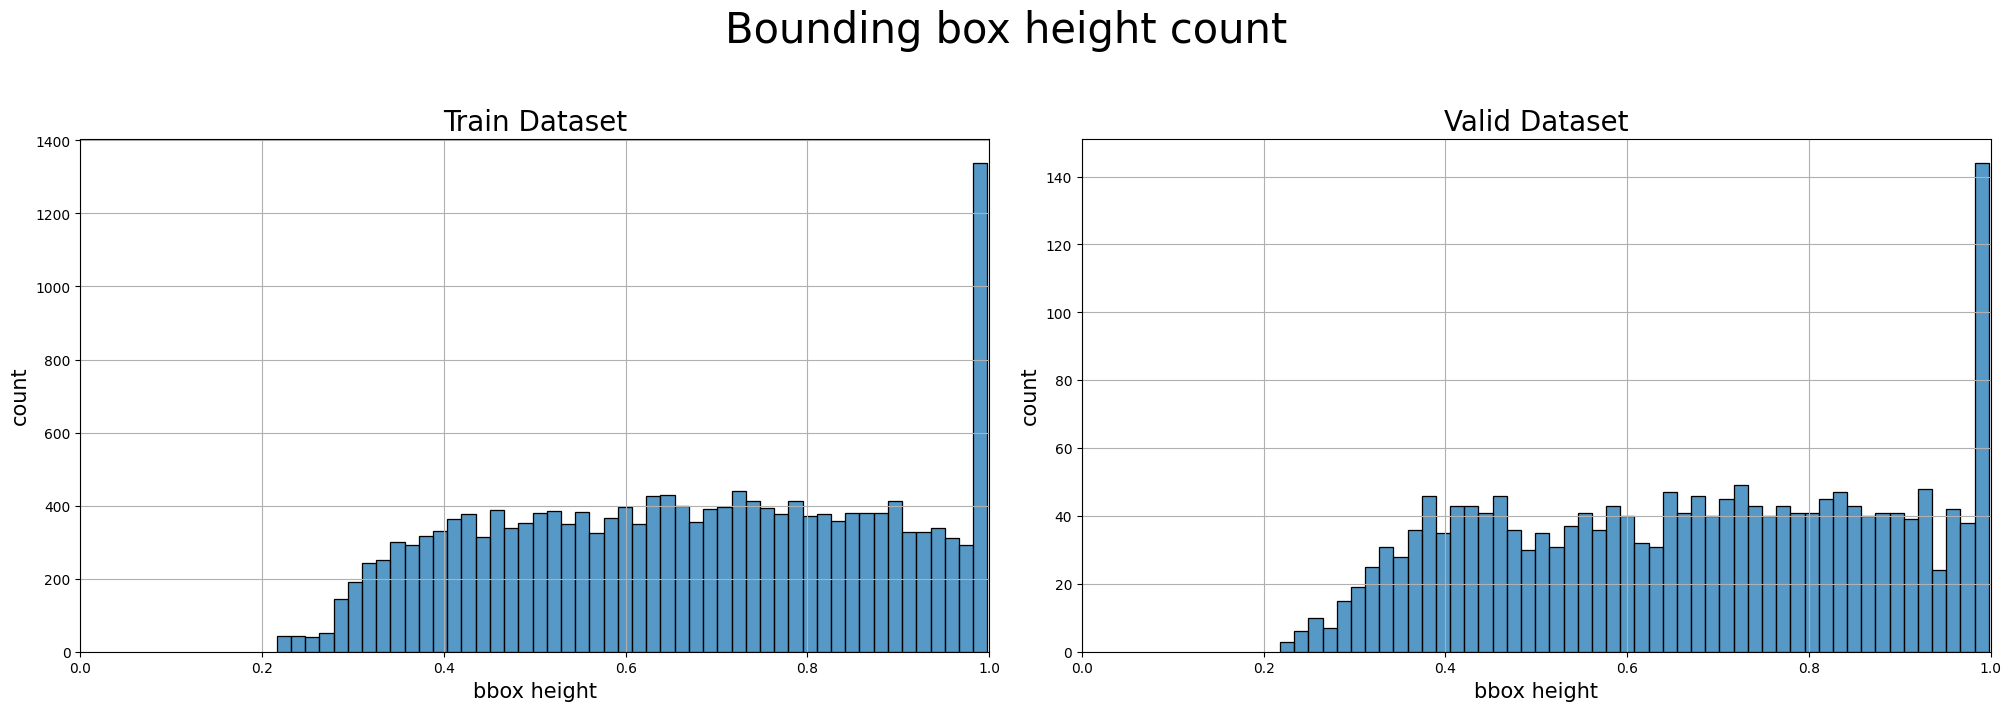

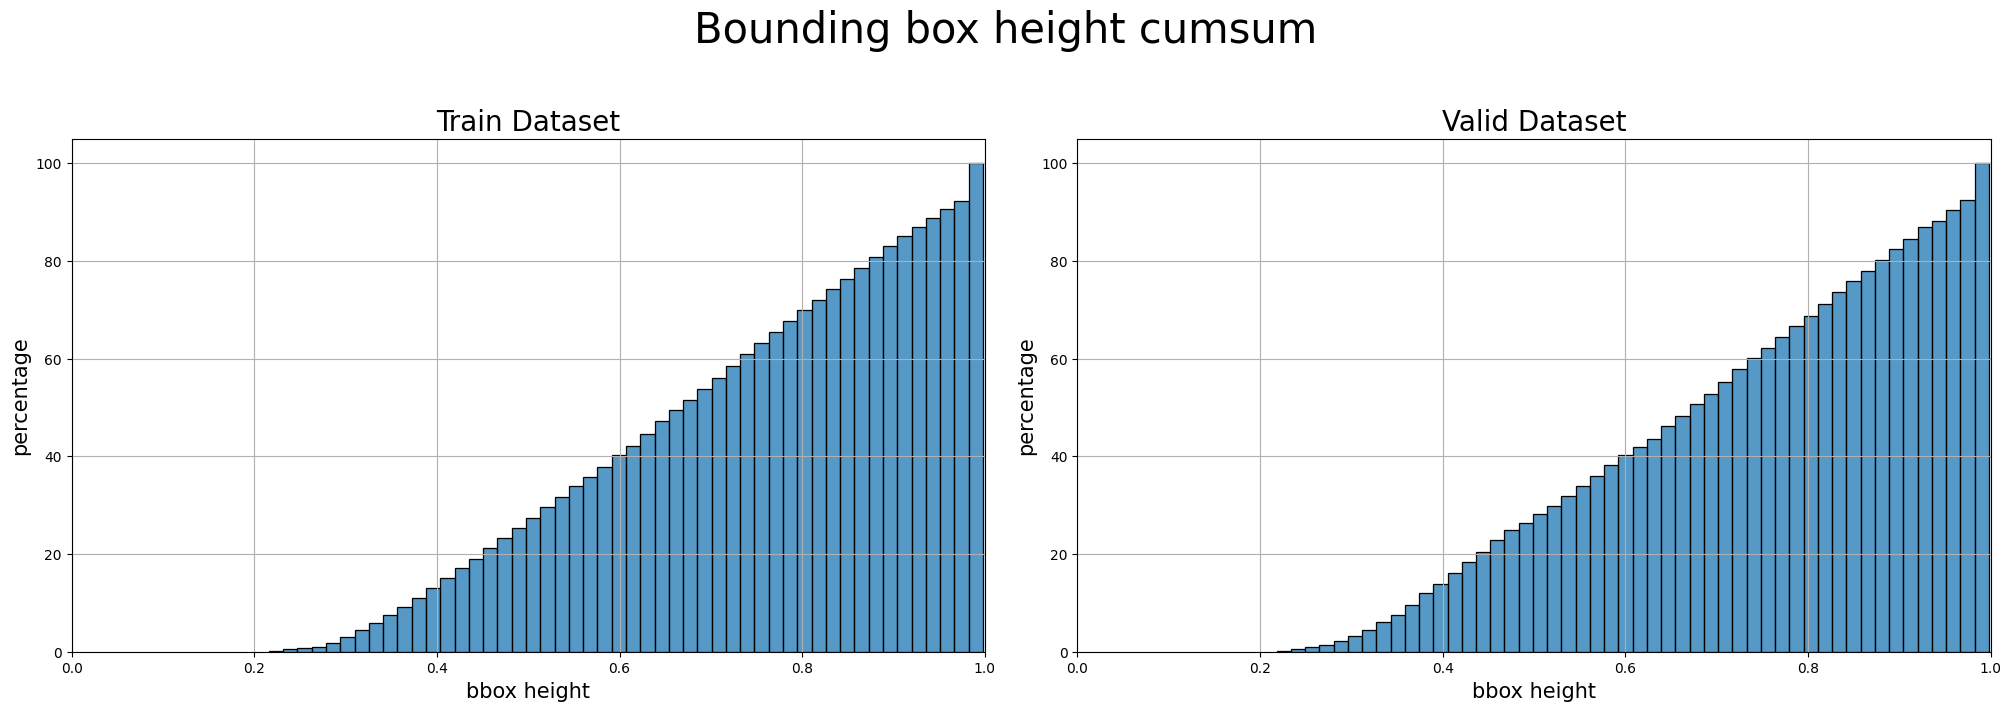

In [12]:
xlim = [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Bounding box height count\n', fontsize=30)

sns.histplot(x=train_df['height'], bins=50, ax=axes[0])
axes[0].set_xlabel('bbox height', fontsize=15)
axes[0].set_xlim(xlim)
axes[0].set_ylabel('count', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='both')

sns.histplot(x=valid_df['height'], bins=50, ax=axes[1])
axes[1].set_xlabel('bbox height', fontsize=15)
axes[1].set_xlim(xlim)
axes[1].set_ylabel('count', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='both')



fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Bounding box height cumsum\n', fontsize=30)

sns.histplot(x=train_df['height'], bins=50, cumulative=True, stat='percent', ax=axes[0])
axes[0].set_xlabel('bbox height', fontsize=15)
axes[0].set_xlim(xlim)
axes[0].set_ylabel('percentage', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='both')

sns.histplot(x=valid_df['height'], bins=50, cumulative=True, stat='percent', ax=axes[1])
axes[1].set_xlabel('bbox height', fontsize=15)
axes[1].set_xlim(xlim)
axes[1].set_ylabel('percentage', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='both')

- 그리드셀 사이즈 7에 대해 1.5 이하의 bbox를 제거한 결과 0.2 이상의 normalized width, height가 남음

## Bounding box 비율

In [13]:
# 세로/가로
aspect_ratio_train_df = train_df['height'] / train_df['width']
aspect_ratio_valid_df = valid_df['height'] / valid_df['width']

In [14]:
print(aspect_ratio_train_df.min(), aspect_ratio_train_df.max())
print(aspect_ratio_valid_df.min(), aspect_ratio_valid_df.max())

0.23076666666666668 4.574923547400611
0.23871686746987952 4.261633428300095


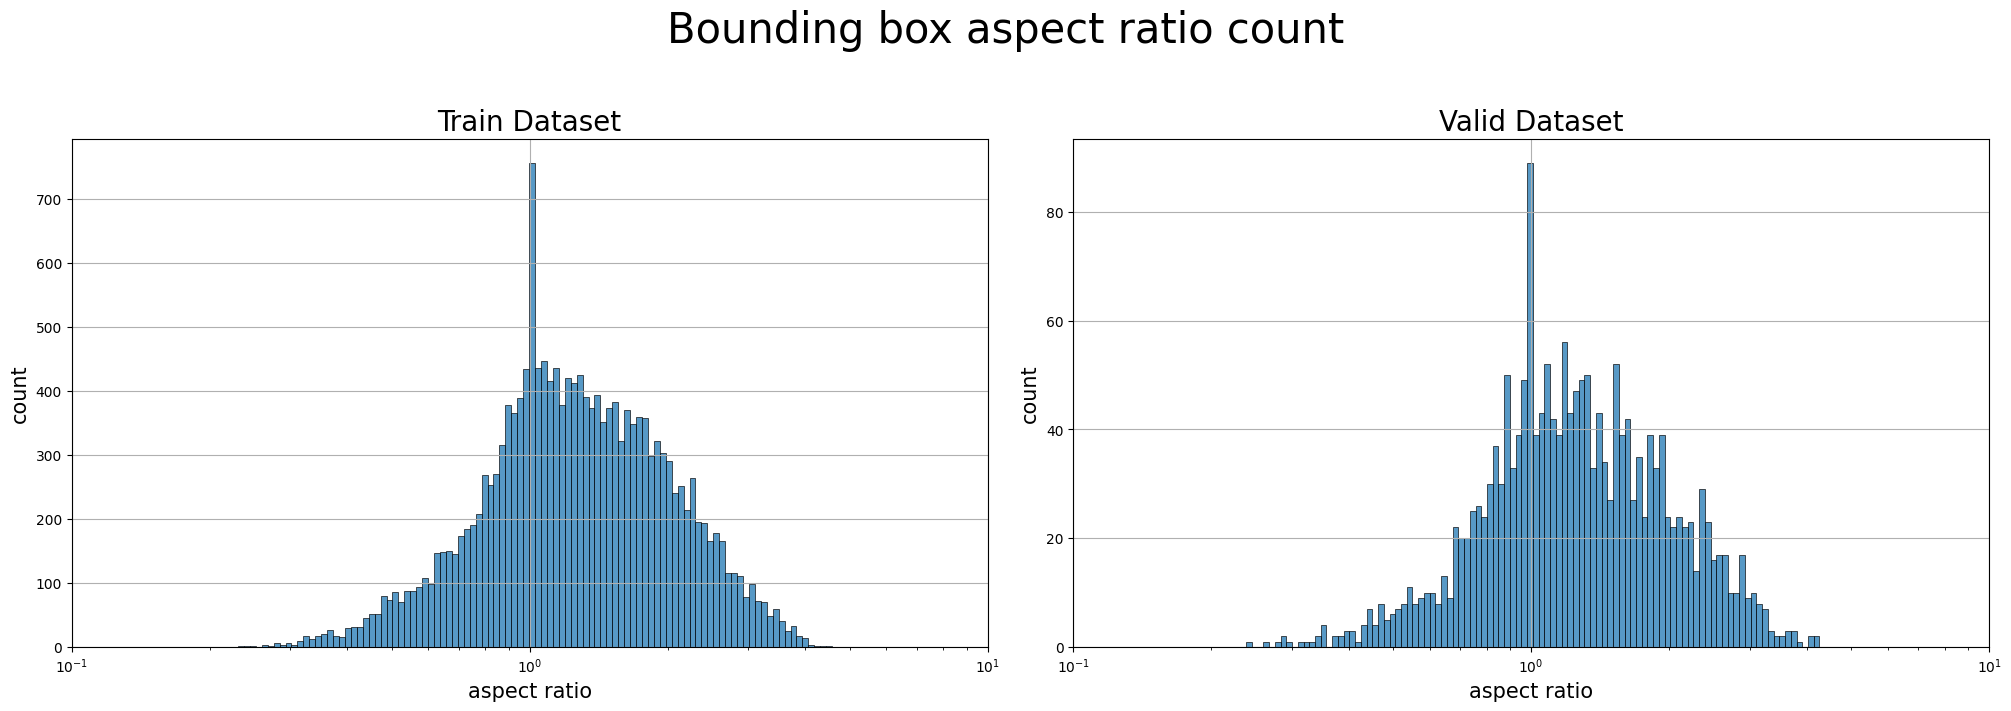

In [15]:
xlim = [1e-1, 1e1]

fig, axes = plt.subplots(1, 2, figsize=(20,7), constrained_layout=True)
plt.suptitle('Bounding box aspect ratio count\n', fontsize=30)
bins = 100

sns.histplot(x=aspect_ratio_train_df, bins=bins, log_scale=10, ax=axes[0])
axes[0].set_xlabel('aspect ratio', fontsize=15)
axes[0].set_xlim(xlim)
axes[0].set_ylabel('count', fontsize=15)
axes[0].set_title('Train Dataset', fontsize=20)
axes[0].grid(True, axis='both')

sns.histplot(x=aspect_ratio_valid_df, bins=bins, log_scale=10, ax=axes[1])
axes[1].set_xlabel('aspect ratio', fontsize=15)
axes[1].set_xlim(xlim)
axes[1].set_ylabel('count', fontsize=15)
axes[1].set_title('Valid Dataset', fontsize=20)
axes[1].grid(True, axis='both')

## RGB 분포

In [16]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from glob import glob


class VOCDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        image = Image.open(img_paths[index]).convert('RGB')
        image = self.transform(image)

        return image


img_paths = glob(os.path.join(img_dir, '*.jpg'))
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])
dataset = VOCDataset(img_paths, transform)
data_loader = DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=False,
)

In [25]:
# from tqdm import tqdm

# N_CHANNELS = 3
# mean = torch.zeros(N_CHANNELS)
# std = torch.zeros(N_CHANNELS)

# img_cnt = 0
# for images in tqdm(data_loader):
#     for i in range(N_CHANNELS):
#         mean[i] += images[:,i,:,:].mean()
#         std[i] += images[:,i,:,:].std()

# print(f"mean: {mean/len(data_loader)}")
# print(f"std: {std/len(data_loader)}")

- VOCdataset (448, 448) 사이즈의 이미지에 대한 평균 및 표준편차
    - 평균 : (0.4526, 0.4316, 0.3996)
    - 표준편차 : (0.2370, 0.2314, 0.2358)

- 참고 이미지넷 평균 및 표준편차
    - 평균 : (0.485, 0.456, 0.406)
    - 표준편차 : (0.229, 0.224, 0.225)

# 그리드셀 좌표에 따른 분석

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import cv2


class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, img_size, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.S, self.B, self.C = S, B, C
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        class_labels = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, w, h = list(label.split(','))
                boxes.append([float(x), float(y), float(w), float(h)])
                class_labels.append(int(class_label))

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=boxes)
            image = augmentations['image']
            boxes = augmentations['bboxes']

        return image, class_labels, boxes

In [18]:
train_csv_path = os.path.join(dataset_dir, 'VocDetection/train.csv')
valid_csv_path = os.path.join(dataset_dir, 'VocDetection/valid.csv')
img_dir = os.path.join(dataset_dir, 'VocDetection/images')
label_dir = os.path.join(dataset_dir, 'VocDetection/labels')

IMAGE_SIZE = 448
S, B, C = 7, 2, 20
scale = 1.1

transform = A.Compose([
    A.LongestMaxSize(max_size=int(IMAGE_SIZE)),
    A.PadIfNeeded(
        min_height=int(IMAGE_SIZE),
        min_width=int(IMAGE_SIZE),
        border_mode=cv2.BORDER_CONSTANT,
    ),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=[]))

train_dataset = VOCDataset(
    train_csv_path,
    img_dir,
    label_dir,
    img_size=IMAGE_SIZE,
    S=S, B=B, C=C,
    transform=transform
)
valid_dataset = VOCDataset(
    valid_csv_path,
    img_dir,
    label_dir,
    img_size=IMAGE_SIZE,
    S=S, B=B, C=C,
    transform=transform
)

voc_classes = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

In [19]:
from tqdm import tqdm
import pandas as pd

def create_df(dataset, S, B, C, voc_classes):
    df = pd.DataFrame(
        columns=[
            'img_index',
            'i',
            'j',
            'x_cell',
            'y_cell',
            'w_cell',
            'h_cell',
            'class_name',
            'duplicated' # 중복되어 셀에서 제외되면 1
    ])

    df_index = 0
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    for img_index, (image, class_labels, bboxes) in enumerate(tqdm(dataloader)):
        label_matrix = torch.zeros(S, S, C + 5 * B)
        for class_label, bbox in zip(class_labels, bboxes):
            class_label = int(class_label)
            class_name = voc_classes[class_label]
            x, y, w, h = bbox

            j = int(S * x)
            i = int(S * y)
            x_cell = float((S * x) - j)
            y_cell = float((S * y) - i)
            w_cell = float(S * w)
            h_cell = float(S * h)

            # convert from midpoint to matrix format
            if label_matrix[i, j, 20] == 0:
                # object score
                label_matrix[i, j, 20] = 1

                # box coordinates
                box_coordinates = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                label_matrix[i, j, 21:25] = box_coordinates

                # onehot encoding for class label
                label_matrix[i, j, class_label] = 1

                # 정상적으로 셀에 할당된 경우
                duplicated = 0
            
            elif label_matrix[i, j, 20] == 1:
                # 이미 셀에 객체가 할당되어 누락되는 경우
                duplicated = 1

            df.loc[df_index] = [
                img_index,
                i,
                j,
                x_cell,
                y_cell,
                w_cell,
                h_cell,
                class_name,
                duplicated
            ]
            df_index += 1

    return df

train_df = create_df(train_dataset, S, B, C, voc_classes)
valid_df = create_df(valid_dataset, S, B, C, voc_classes)

100%|██████████| 1348/1348 [00:12<00:00, 104.14it/s]


## 그리드셀 별 bbox 분포

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

df1 = train_df
df1['dataset'] = 'train'
df2 = valid_df
df2['dataset'] = 'valid'

hue_order = ['train', 'valid']

df = pd.concat([df1, df2])

In [40]:
cell_df = df[(df['i'] == 0)]
max(cell_df['j'].value_counts())

4

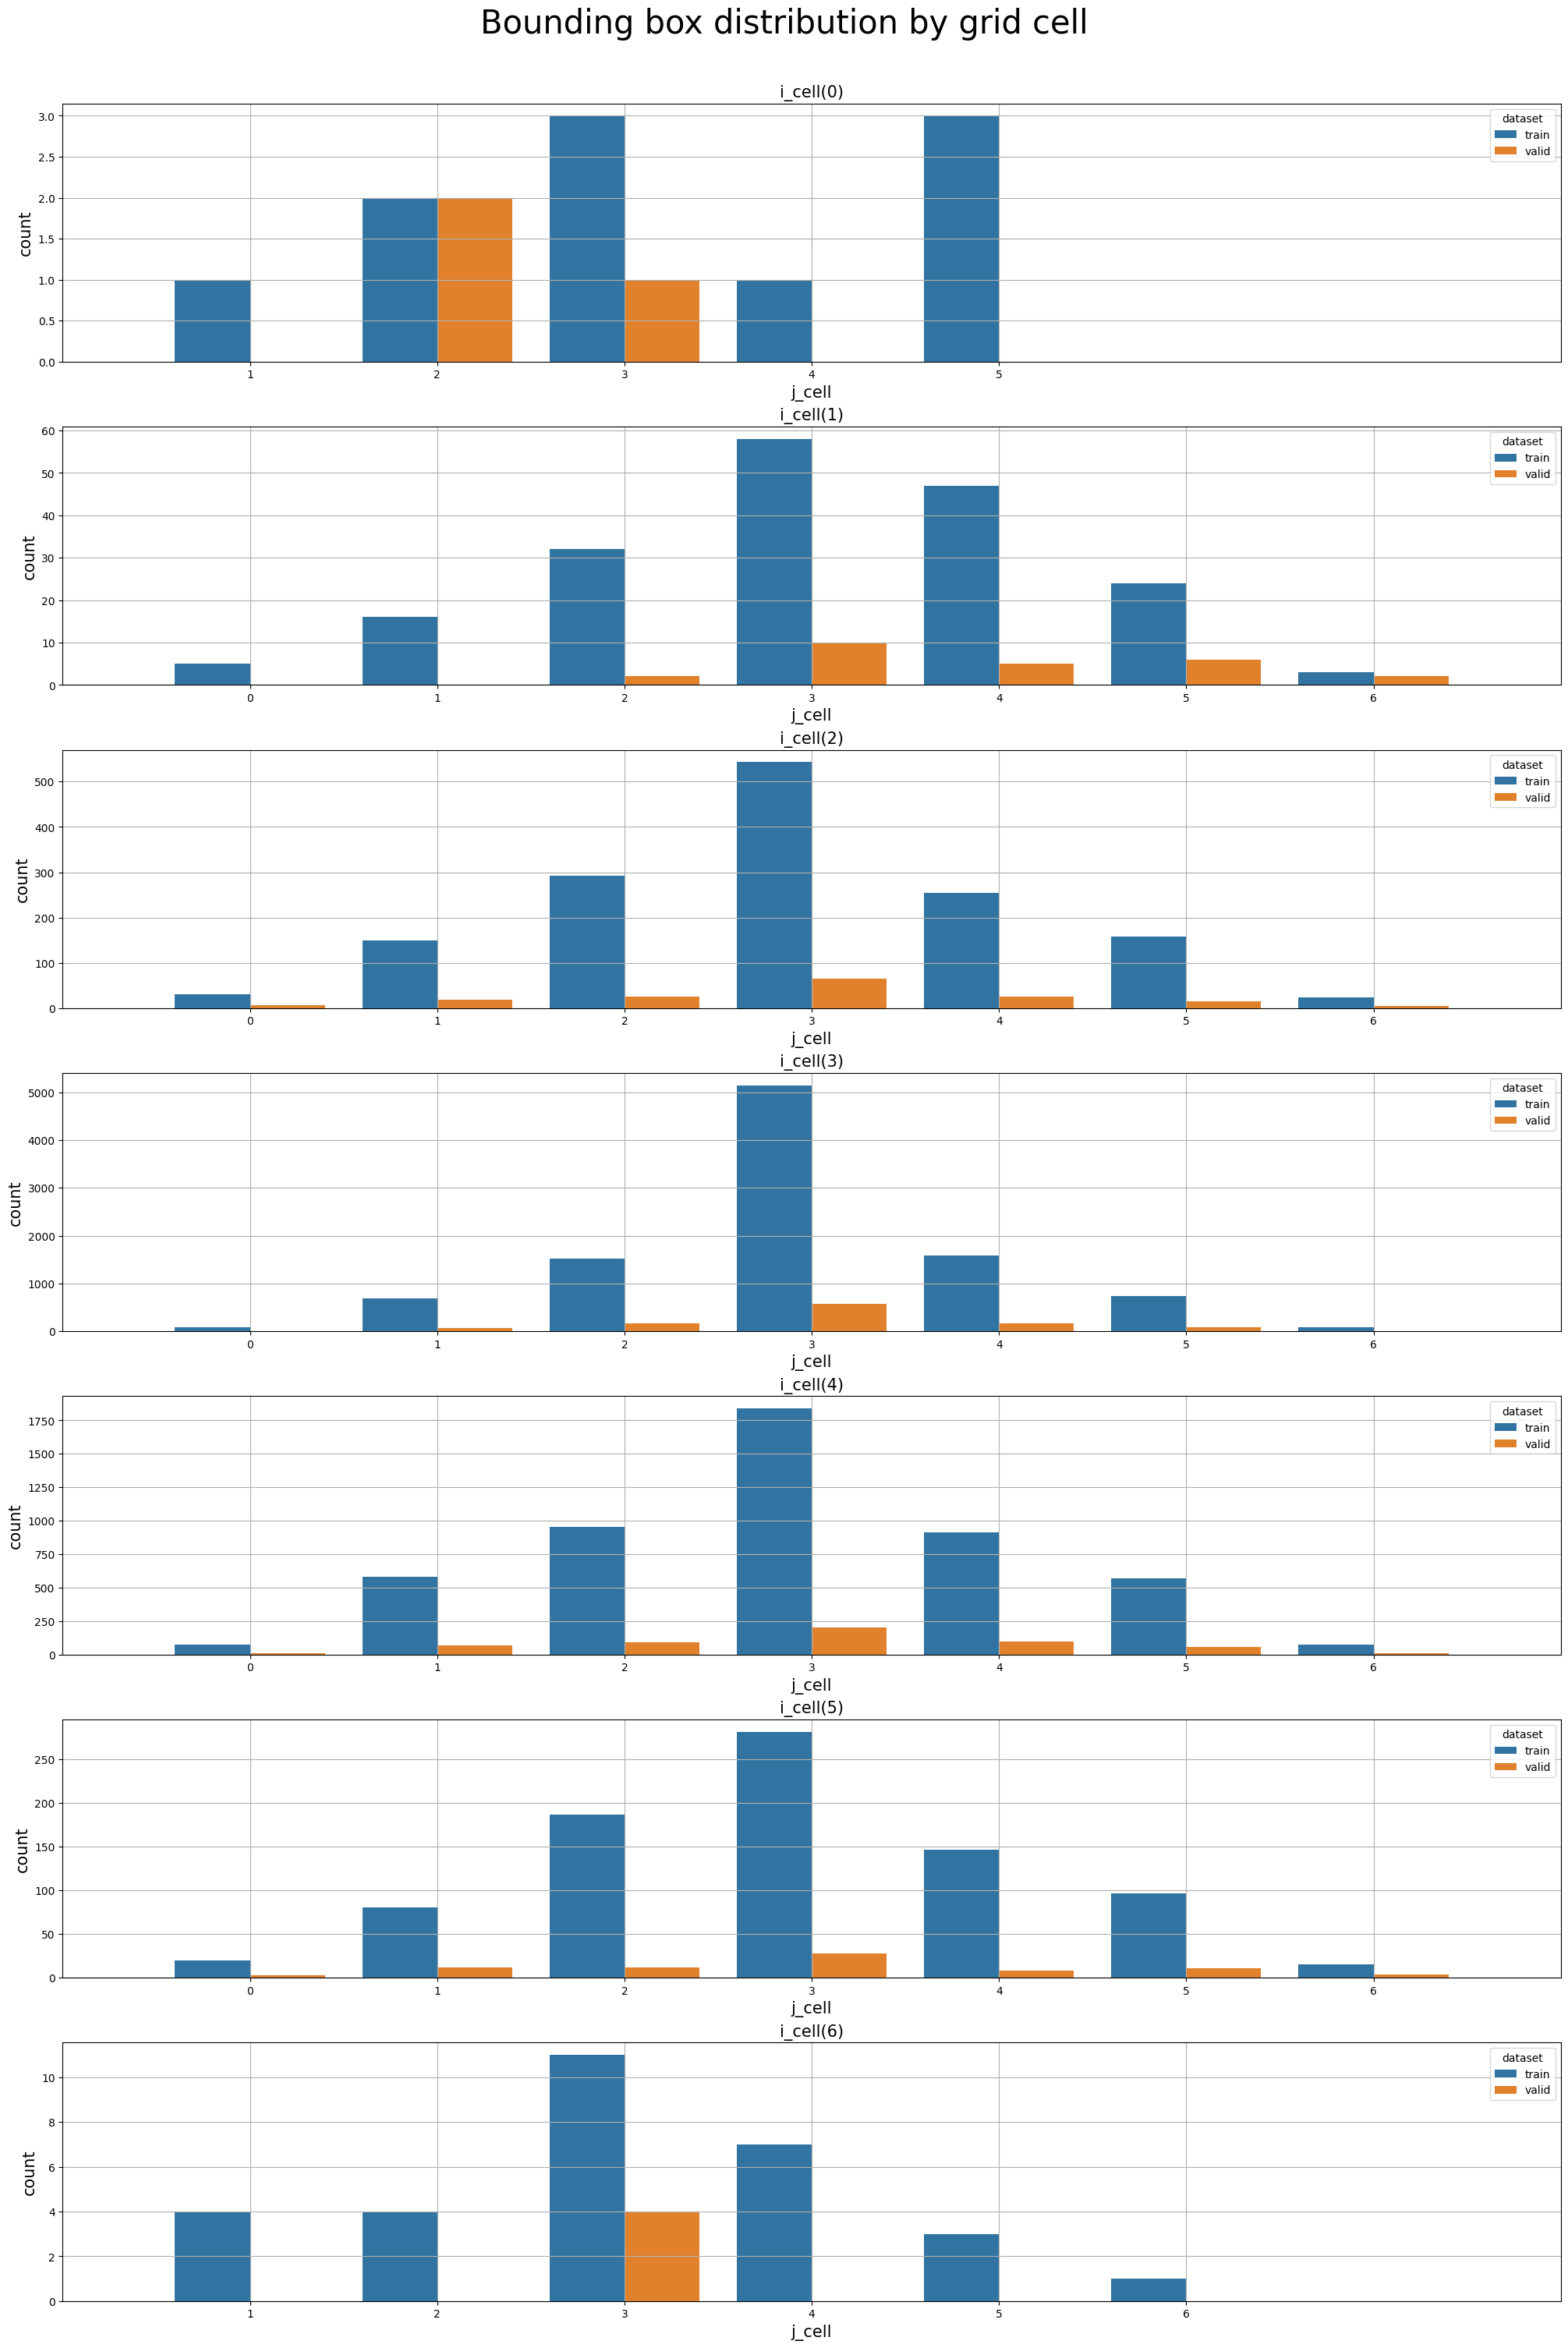

In [51]:
fig, axes = plt.subplots(S, 1, figsize=(20,30), constrained_layout=True)
plt.suptitle('Bounding box distribution by grid cell\n', fontsize=30)

for i in range(S):
    cell_df = df[(df['i'] == i)]
    
    sns.countplot(data=cell_df, x='j', hue='dataset', hue_order=hue_order, ax=axes[i])
    axes[i].set_xlabel('j_cell', fontsize=15)
    axes[i].set_ylabel('count', fontsize=15)
    axes[i].set_xlim([-1, S])
    axes[i].set_title(f'i_cell({i})', fontsize=15)
    axes[i].grid(True, axis='both')
    

- 이미지의 모서리 근처의 데이터 개수가 극적으로 감소하였다.
- 모서리 근처에는 객체가 잘려있거나 가로 세로 폭이 작은 이미지들이 분포해있던 걸로 보인다.

## 그리드셀 별 누락된 bbox 분포

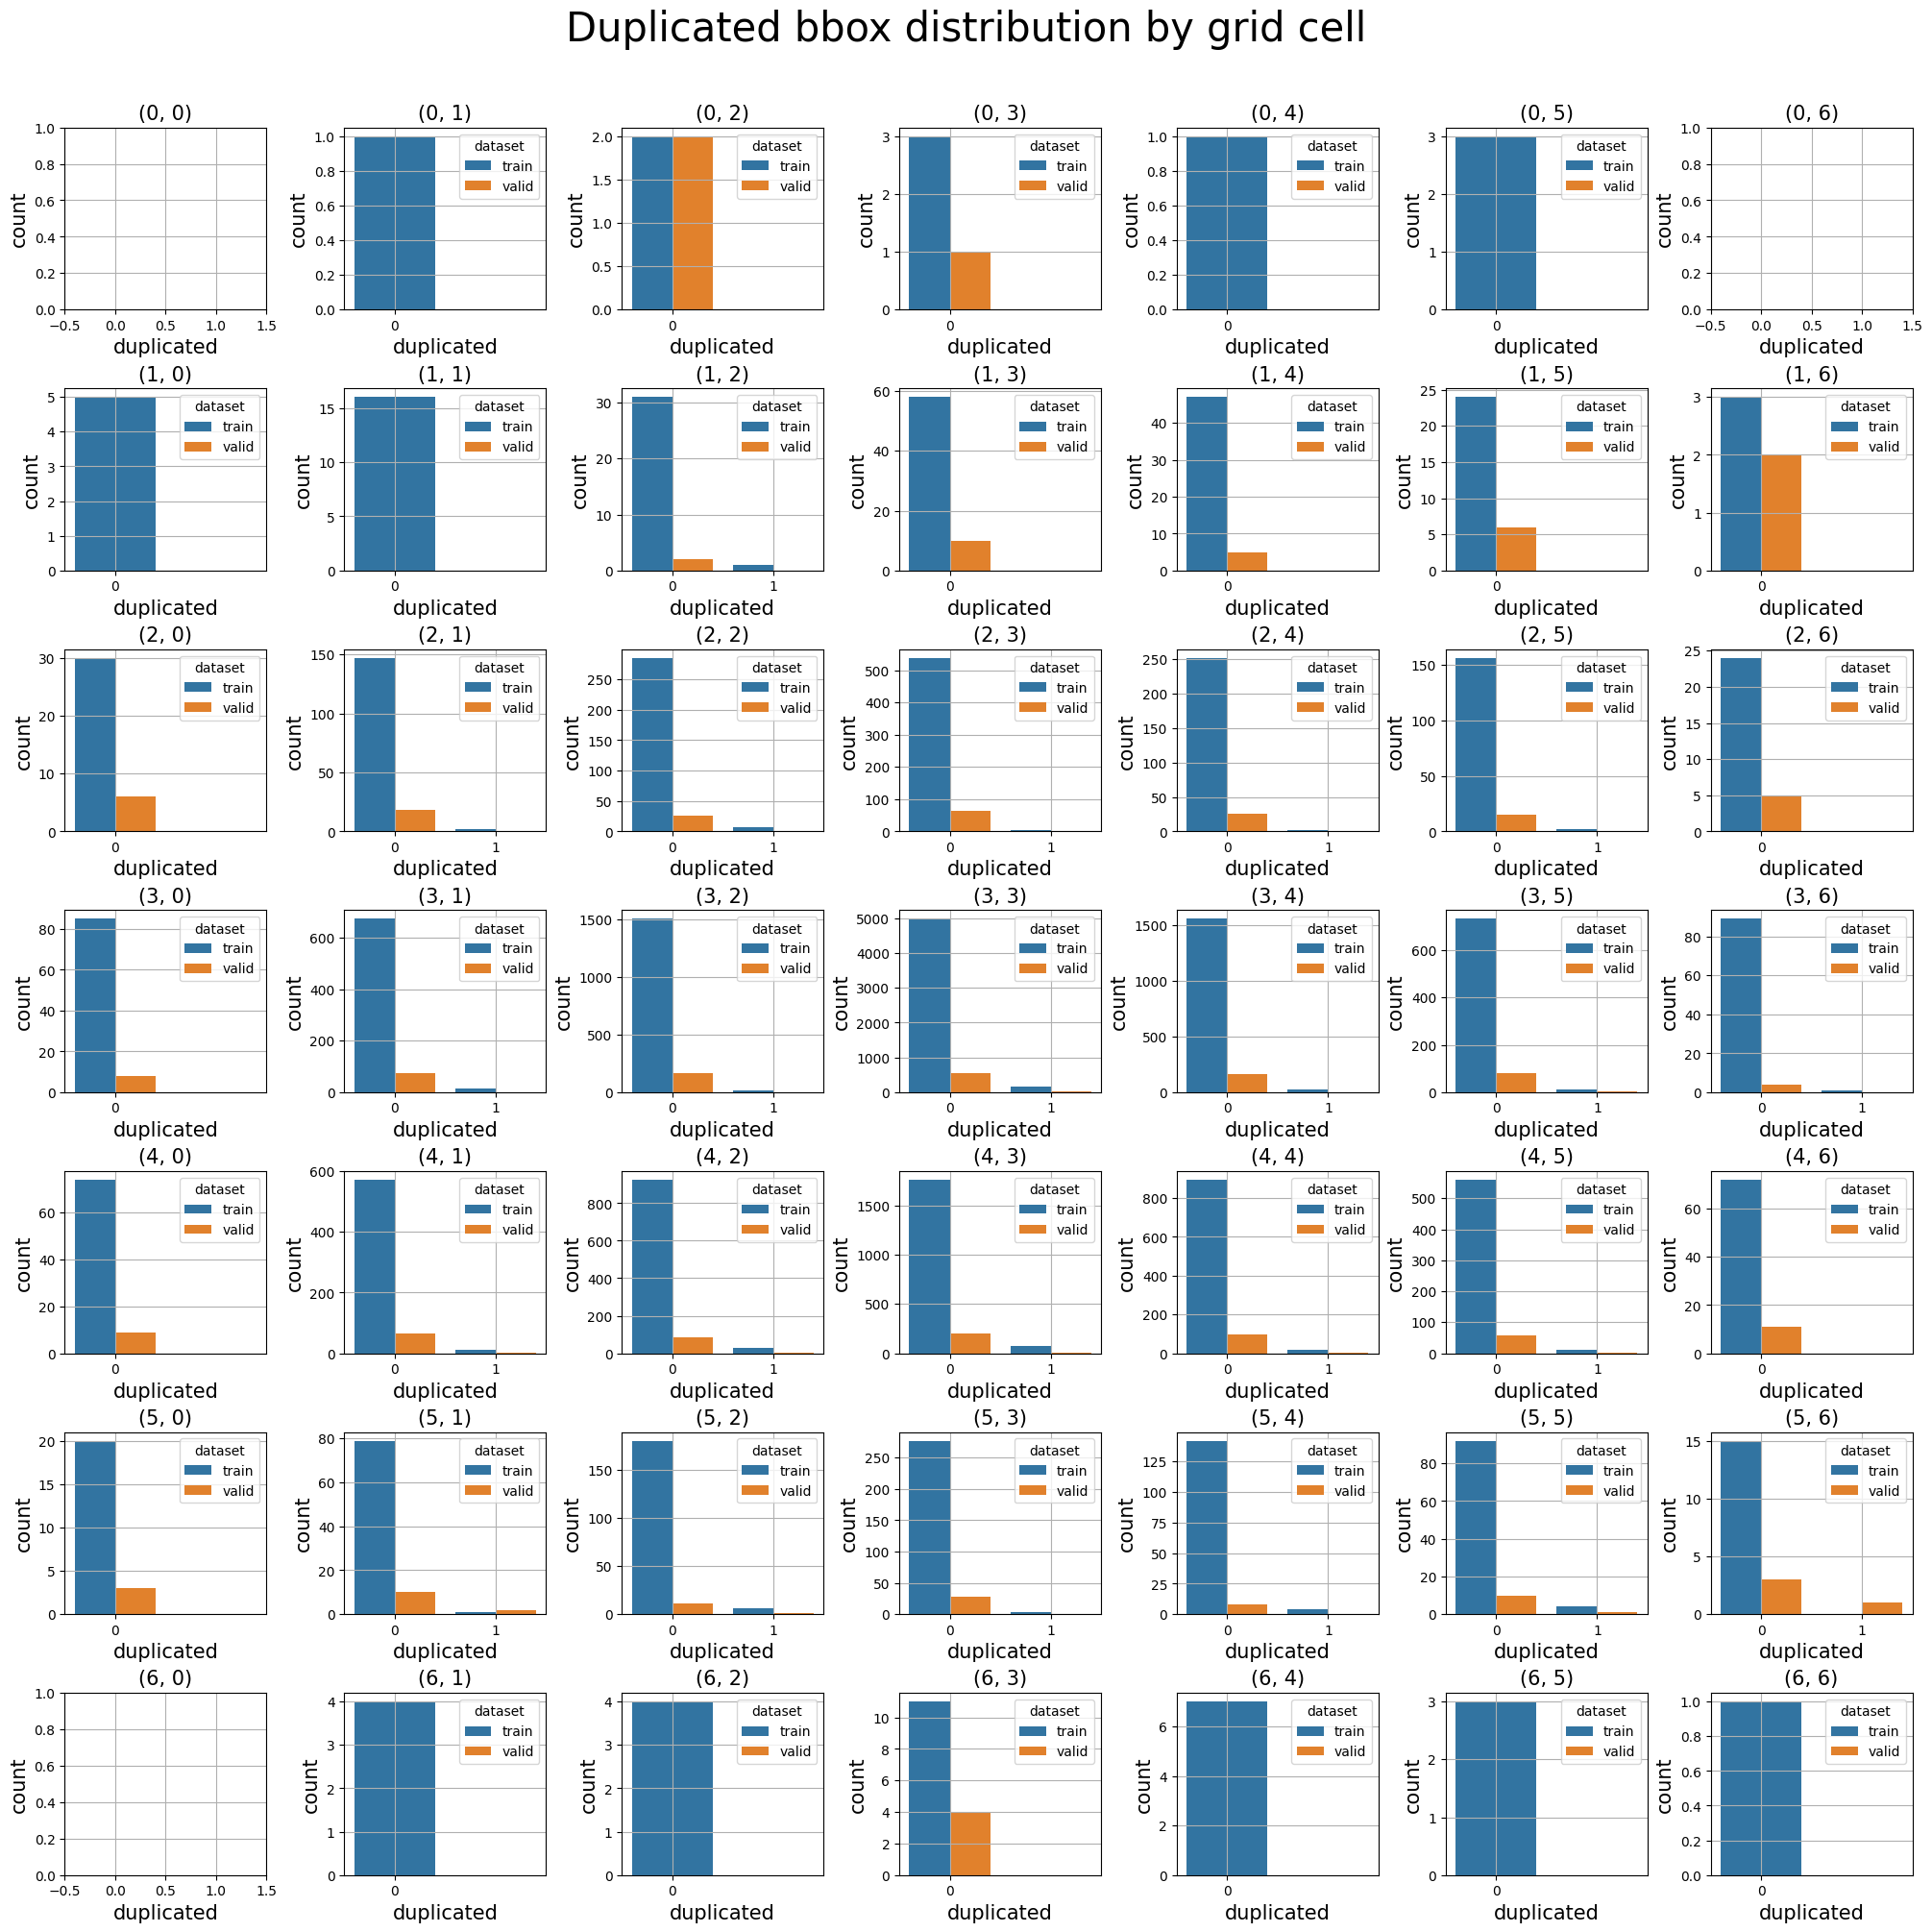

In [52]:
fig, axes = plt.subplots(S, S, figsize=(20,20), constrained_layout=True)
plt.suptitle('Duplicated bbox distribution by grid cell\n', fontsize=30)

for i in range(S):
    for j in range(S):
        class_df = df[(df['i'] == i) & (df['j'] == j)]
        
        sns.countplot(data=class_df, x='duplicated', hue='dataset', hue_order=hue_order, ax=axes[i, j])
        axes[i][j].set_xlabel('duplicated', fontsize=15)
        axes[i][j].set_ylabel('count', fontsize=15)
        axes[i][j].set_xlim([-0.5, 1.5])
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='both')

- 그리드셀에 이미지를 할당하는 과정에서도 누락되는 이미지가 거의 사라졌다.
- 작은 사이즈들의 객체들은 인접하여 분포하는 경향이 있던 것으로 보인다.

## 그리드셀 별 클래스 분포

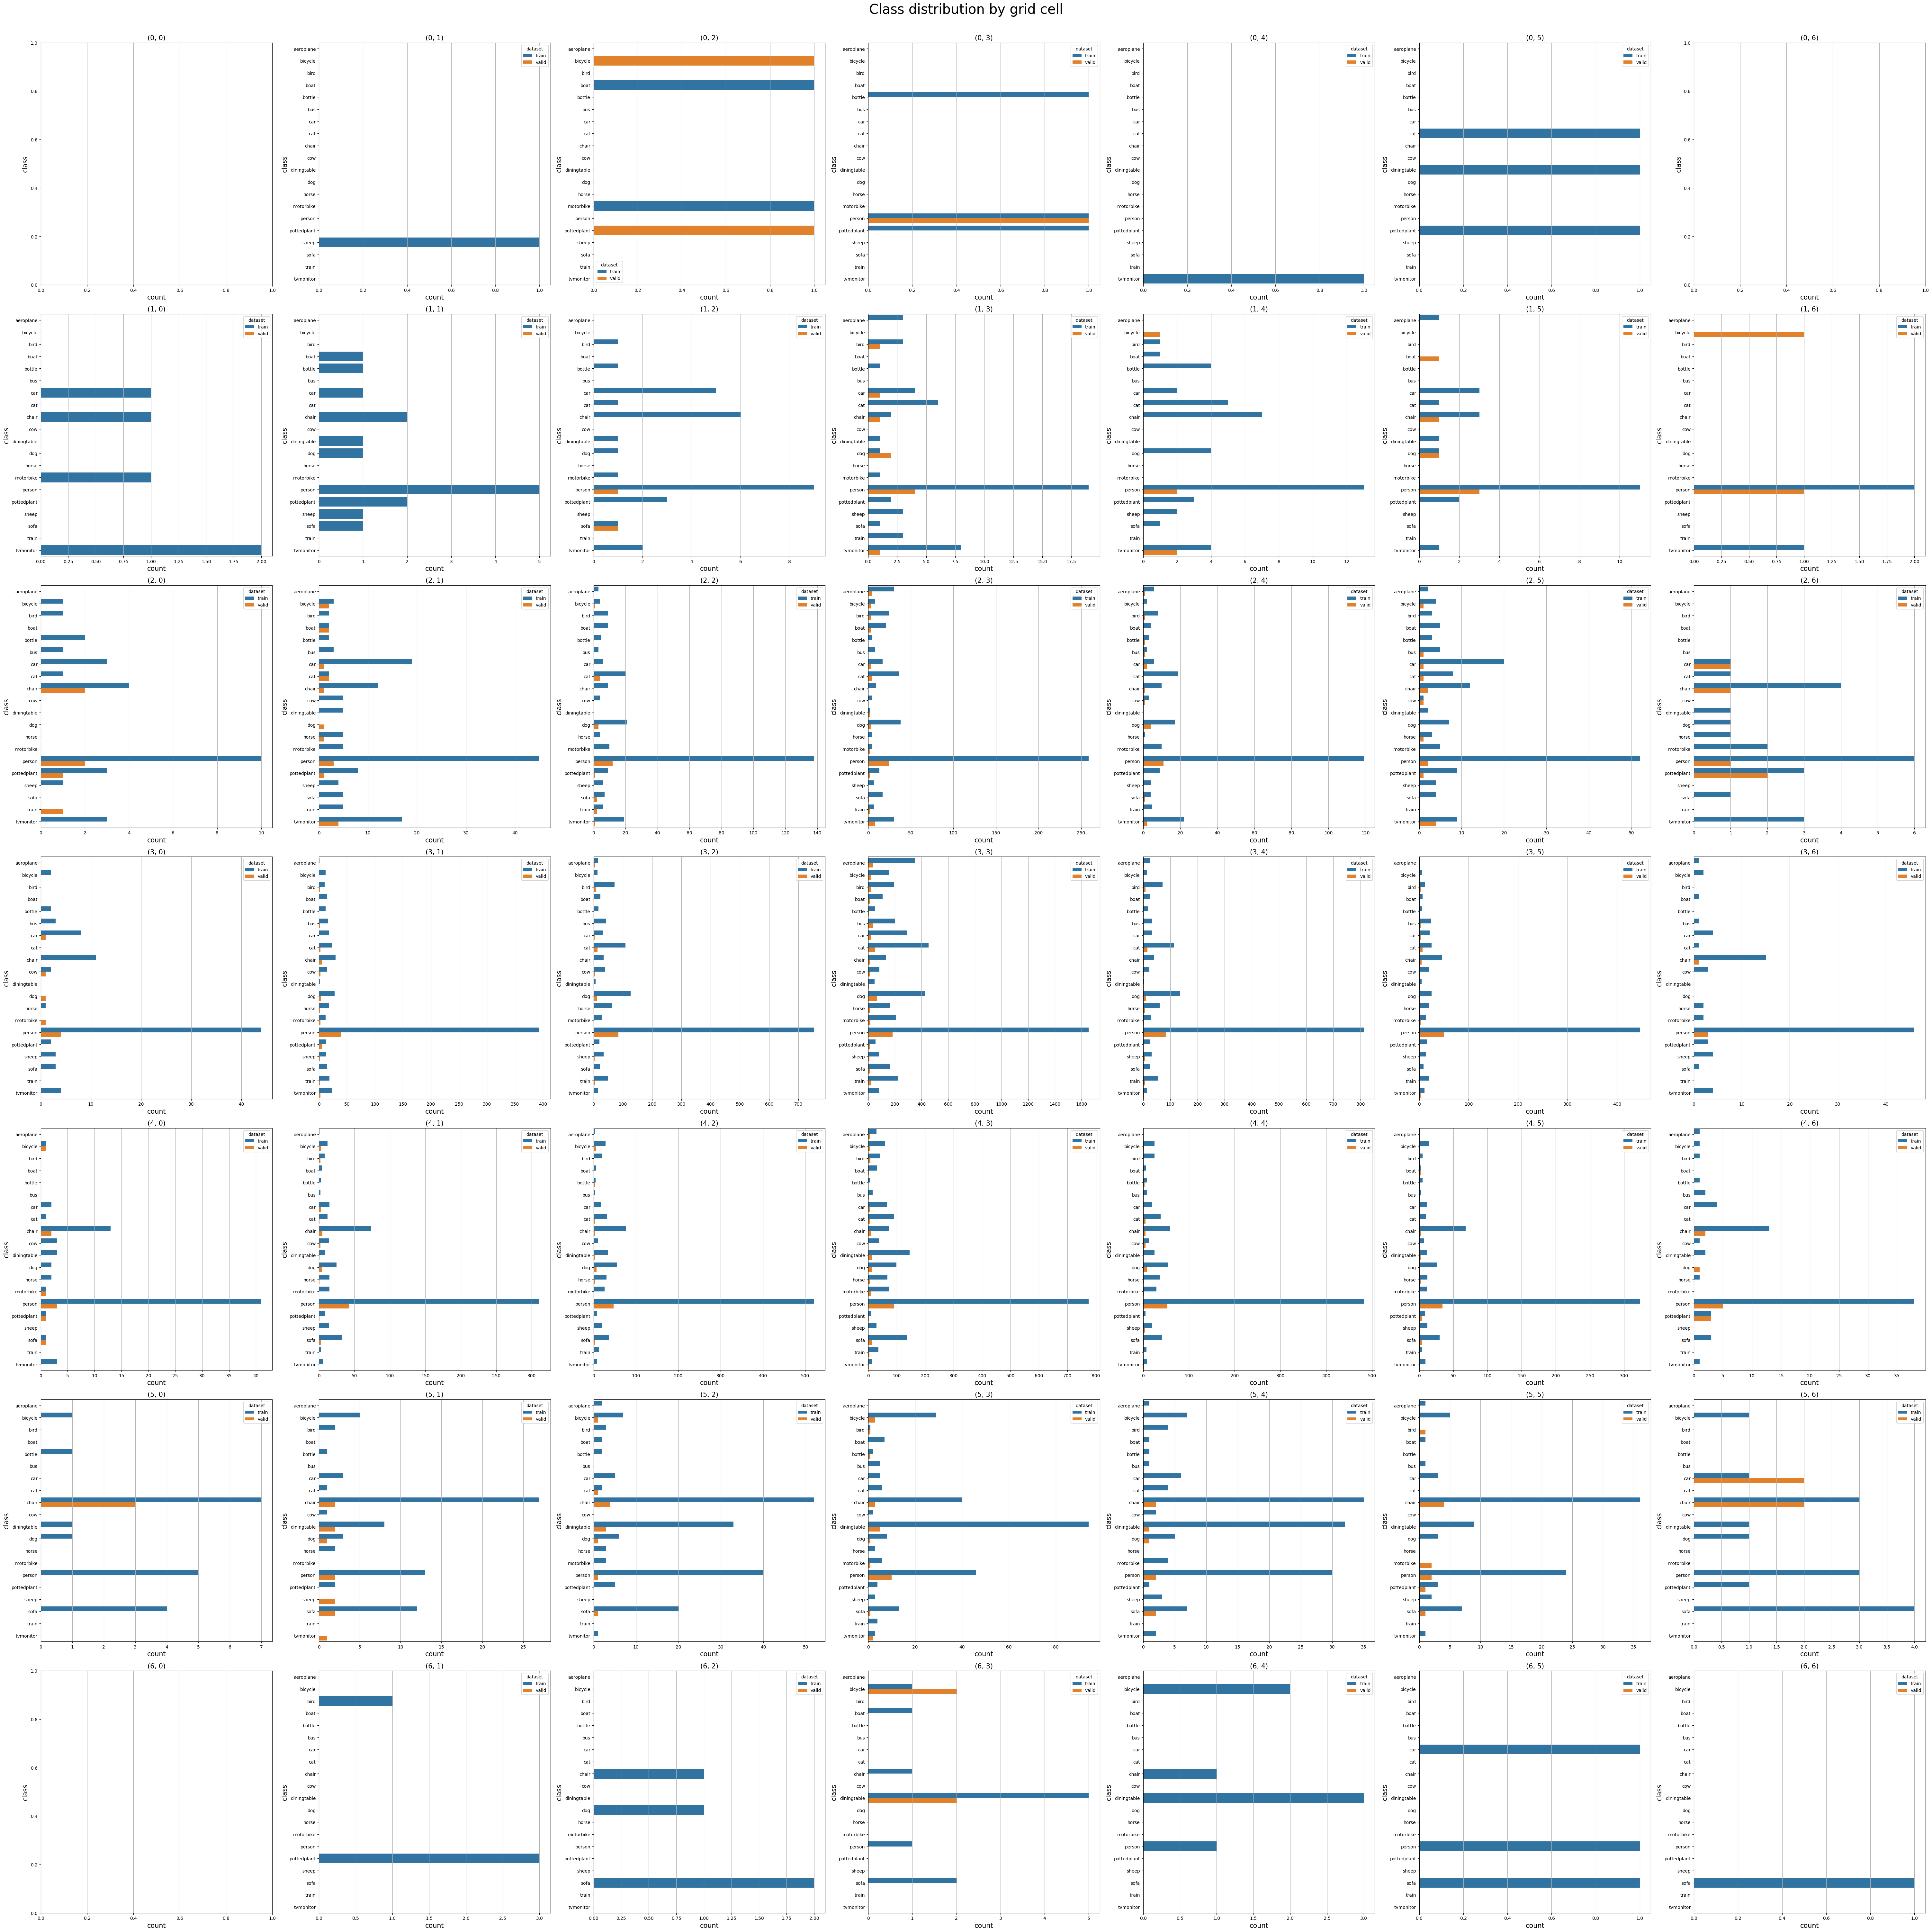

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(S, S, figsize=(60,60), constrained_layout=True)
plt.suptitle('Class distribution by grid cell\n', fontsize=30)

for i in range(S):
    for j in range(S):
        class_df = df[(df['i'] == i) & (df['j'] == j)]
        
        sns.countplot(data=class_df, y='class_name', hue='dataset', hue_order=hue_order, order=voc_classes, ax=axes[i, j])
        axes[i][j].set_xlabel('count', fontsize=15)
        axes[i][j].set_ylabel('class', fontsize=15)
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='x')

- valid dataset의 모서리 근처의 셀에는 train datset에 없는 학습하지 못한 소수의 클래스들이 나타난다.
- 하지만 기존 데이터셋 대비 크게 감소하였다.
- 중앙에 위치한 셀에서는 학습하지 못하는 클래스는 없을 것으로 보인다.